# Test & Results

## Preparing the data

In [251]:
import pandas as pd
import numpy as np
import pickle

import cv2

from datetime import datetime
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

import requests
import os
import shutil

import warnings

warnings.filterwarnings('ignore')

## Load the data

In [252]:
df_origin = pd.read_csv('df_test.csv', parse_dates=['Original Release Date' , 'Current Version Release Date'])
df_old = pd.read_csv('preprocessed_data.csv')
df_old = df_old.drop(['Average User Rating'], axis=1)

In [253]:
# drop Primary Genre
df_origin.drop(['Primary Genre', 'ID', 'URL'], axis=1, inplace=True)

## Download the icons

In [ ]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons_test'):
    os.makedirs('icons_test')

# Download the images
for i, row in tqdm(df_origin.iterrows(), total=df_origin.shape[0]):
    if not os.path.exists(f'icons_test/{i}.png'):
        download_image(row['Icon URL'], f'icons_test/{i}.png')

## Reviews

In [254]:
sia_reviews = pickle.load(open('encoders/sia_reviews.pkl', 'rb'))

def sentiment_analysis(data):
  
  # Apply sentiment analysis for each review in the list
  data['Reviews'] = data['Reviews'].apply(lambda x: [sia_reviews.polarity_scores(review)['compound'] for review in x])
  
  return data


def reviews_preprocess(data):
  data['Reviews'] = data['Reviews'].astype(str)
  data['Reviews'] = data['Reviews'].str.strip('[]').str.replace("'", "").str.split(", ")
  
  # Apply sentiment_analysis
  data = sentiment_analysis(data)
  
  # Get the lowest, highest and average Reviews
  data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else 0)
  data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else 0)
  data['average_review'] = data['Reviews'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
  
  ## Drop nulls of sentiment
  # data = data.dropna(subset=['lowest_review','highest_review','average_review'])
  return data

## Dates, Developer, Age Rating, Purchases and Price

In [255]:
### Dates

def date_preprocess(_df):
    # Convert the datetime to ordinal
    _df['Original Release Date'] = _df['Original Release Date'].apply(lambda x: x.toordinal())
    _df['Current Version Release Date'] = _df['Current Version Release Date'].apply(lambda x: x.toordinal())
    
    # Fill the missing values with the median
    _df['Original Release Date'] = _df['Original Release Date'].fillna(_df['Original Release Date'].median())
    _df['Current Version Release Date'] = _df['Current Version Release Date'].fillna(_df['Current Version Release Date'].median())
    
    # Create a new column with the age of the game
    _df['game_age'] = datetime.now().toordinal() - _df['Original Release Date']

    # Create a new column with the time since the last update
    _df['last_update'] = datetime.now().toordinal() - _df['Current Version Release Date']
    
    # Create a new column with the maintaning period
    _df['maintaning_period'] = _df['last_update'] - _df['game_age']

    return _df



In [256]:
### Developer

def dev_preprocess_target_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    dev_df = pd.read_csv('encoders/dev_avg.csv')
    dev_df['Average User Rating'] = dev_df['Average User Rating'].astype(float)
    dev_df['Developer'] = dev_df['Developer'].astype(str)

    # Get developers that are unseen in the test set
    unseen_dev = _df['Developer'][~_df['Developer'].isin(dev_df['Developer'])].unique()
    
    # Replace the unseen developers with the 'Other'
    _df['Developer'] = _df['Developer'].replace(unseen_dev, 'Other')

    # Replace the developer with the rating from dev_df
    _df['dev_avg'] = _df['Developer'].replace(dev_df.set_index('Developer')['Average User Rating'])
    
    return _df


def dev_preprocess_freq_enc(_df):
    # Convert to string
    _df['Developer'] = _df['Developer'].astype(str)
    _df['Developer'] = _df['Developer'].str.replace("'", "").str.strip('[]')
    
    # Get the frequency of each developer
    dev_freqs = pd.read_csv('encoders/dev_freq.csv')
    
    # Create a dictionary mapping developers to frequencies
    dev_freq_dict = dict(zip(dev_freqs['Developer'], dev_freqs['Frequency']))

    # Create a new column with the frequency of each developer
    _df['dev_freq'] = _df['Developer'].map(dev_freq_dict)
    
    # Fill the missing values with 1 (the minimum frequency)
    _df['dev_freq'] = _df['dev_freq'].fillna(1)
        
    return _df

In [257]:
### Age Rating

def age_preprocess(_df):
    # Convert to string
    _df['Age Rating'] = _df['Age Rating'].astype(str)

    # Remove the + sign
    _df['Age Rating'] = _df['Age Rating'].str.replace('+', '')

    # Convert to int
    _df['Age Rating'] = _df['Age Rating'].astype(float)

    # fill the missing values with the median
    _df['Age Rating'] = _df['Age Rating'].fillna(df_old['Age Rating'].median())
    
    return _df

In [258]:
### Purchases

# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

def purchases_preprocess(_df):
    # Convert to string

    _df['In-app Purchases'] = _df['In-app Purchases'].astype(str)
    _df['In-app Purchases'] = _df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Convert to float
    _df['In-app Purchases'] = _df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

    # Get the number of in-app purchases
    _df['purchases_count'] = _df['In-app Purchases'].apply(lambda x: len(x))

    # Get the lowest, highest and average purchase
    _df['lowest_purchase'] = _df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
    _df['highest_purchase'] = _df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
    _df['average_purchase'] = _df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)

    _df['lowest_purchase'] = _df['lowest_purchase'].fillna(0)
    _df['highest_purchase'] = _df['highest_purchase'].fillna(0)
    _df['average_purchase'] = _df['average_purchase'].fillna(0)
    
    return _df

In [259]:
### Price

def price_preprocess(_df):
    # Convert to float
    _df['Price'] = _df['Price'].astype(float)

    # fill the missing values with 0 (free)
    _df['Price'] = _df['Price'].fillna(0)
    
    return _df


## Genres & Languages

In [260]:
def genres_preprocess_dummies(_df):
    # Convert to string
    _df['Genres'] = _df['Genres'].astype(str)
    _df['Genres'] = _df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

    # drop Games, Strategy, Entertainment from the Genres column
    _df['Genres'] = _df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

    # Load saved genres dummy variables
    saved_dummies = pd.read_csv('encoders/genres.csv')

    # Get the genres that are not in the saved dummy variables
    other = [genre for genre in _df['Genres'].explode().unique() if genre not in saved_dummies.columns]

    # Replace the genres that are not in the saved dummy variables with 'infrequent'
    _df['Genres'] = _df['Genres'].apply(lambda x: ['infrequent' if genre in other else genre for genre in x])

    # Preprocess test data using the saved dummy variables
    test_dummies = pd.get_dummies(_df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)
    test_dummies = test_dummies.reindex(columns=saved_dummies.columns, fill_value=0)
    
    # Fill the dummy columns with 0 if nan
    test_dummies = test_dummies.fillna(0)

    # Add the new dummy variables to the test data
    _df = pd.concat([_df, test_dummies], axis=1)
    
    # Fill NaN with 0
    genre_cols = [col for col in _df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
    _df[genre_cols] = _df[genre_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df


In [261]:
def langs_preprocess_dummies(_df):
    # Convert the langs column to a list of strings
    _df['Languages'] = _df['Languages'].astype(str)
    _df['Languages'] = _df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

    # Create a column with the number of languages supported
    _df['langs_count'] = _df['Languages'].apply(lambda x: len(x))

    # Drop the English language from the Languages column (it is the most common language and would dominate the model)
    _df['Languages'] = _df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

    # Load saved languages dummy variables
    saved_dummies = pd.read_csv('encoders/langs.csv')

    # Get the languages that are not in the saved dummy variables
    other = [lang for lang in _df['Languages'].explode().unique() if lang not in saved_dummies.columns]

    # Replace the languages that are not in the saved dummy variables with 'infrequent'
    _df['Languages'] = _df['Languages'].apply(lambda x: ['infrequent' if lang in other else lang for lang in x])

    # Preprocess test data using the saved dummy variables
    test_dummies = pd.get_dummies(_df['Languages'].apply(pd.Series).stack(), prefix="lang", dummy_na=False).sum(level=0)
    test_dummies = test_dummies.reindex(columns=saved_dummies.columns, fill_value=0)

    # Fill the dummy columns with 0 if nan
    test_dummies = test_dummies.fillna(0)

    # Concatenate dummies to original DataFrame
    _df = pd.concat([_df, test_dummies], axis=1)

    # Fill NaN with 0
    lang_cols = [col for col in _df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
    _df[lang_cols] = _df[lang_cols].fillna(0) # fill NaN with 0 for selected columns
    
    return _df


## NLP preprocessing

In [262]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def preprocess_nlp(_df, col):
    _df[col] = _df[col].astype(str)

    # Remove URLs and email addresses
    _df[col] = _df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    _df[col] = _df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    stop = stopwords.words('english')
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Stemming
    st = nltk.PorterStemmer()
    _df[col] = _df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    _df[col] = _df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(_df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    _df[col] = _df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    _df[col] = _df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    _df[col] = _df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = pickle.load(open(f'encoders/vectorizer_{col}.pkl', 'rb'))
    BoW = vectorizer.transform(_df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = pickle.load(open(f'encoders/pca_{col}.pkl', 'rb'))
    pca_col = pca_.transform(BoW.toarray())

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        _df[f'{col}_PCA_{feat}'] = pca_col[:, feat]
        
    return _df



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yusuf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Icon

In [263]:
def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [264]:
def icons_preprocess(_df):
    # Create a list to store the feature vectors
    icon_features = []

    _df['Icon URL'] = _df['Icon URL'].astype(str)

    # Iterate over the images and extract the features
    for i, row in tqdm(_df.iterrows(), total=_df.shape[0]):
        feature_vec = preprocess_icon(row['Icon URL'])
        icon_features.append((row['Icon URL'], feature_vec))
        
    # Apply PCA to reduce the number of features
    pca = pickle.load(open('encoders/icon_pca.pkl', 'rb'))

    reduced_features = pca.transform([f[1] for f in icon_features])

    # Convert the reduced features to a dataframe
    icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                        'Icon1': reduced_features[:,0],
                                        'Icon2': reduced_features[:,1],
                                        'Icon3': reduced_features[:,2],
                                        'Icon4': reduced_features[:,3]})

    # Merge the icon features with the original dataframe on the icon URL
    _df = _df.merge(icon_features_df, on='Icon URL', how='left')
    
    return _df

In [265]:
# load the Sentiment Intensity Analyzer models
sia_desc = pickle.load(open('encoders/sia_desc.pkl', 'rb'))
sia_name = pickle.load(open('encoders/sia_name.pkl', 'rb'))
sia_sub = pickle.load(open('encoders/sia_sub.pkl', 'rb'))

# tokenize the text into words and count how many attractive keywords appear
tokenizer = pickle.load(open('encoders/nltk_word_tokenize.pkl', 'rb'))

def compute_excitement_score(text, _sia):
    
    # compute the polarity scores for the given text
    scores = _sia.polarity_scores(text)
    
    # compute the excitement score as the sum of the positive and negative polarity scores
    excitement_score = scores['pos'] + abs(scores['neg'])
    
    return excitement_score

# define a function to compute an attractive score from a given text
def compute_attractive_score(text):
    # define a list of keywords that might make a game attractive to users
    attractive_keywords = ['graphics', 'gameplay', 'storyline', 'characters']
    
    words = tokenizer(text.lower())
    num_attractive_keywords = len([word for word in words if word in attractive_keywords])
    
    # compute the attractive score as the ratio of attractive keywords to total words
    attractive_score = num_attractive_keywords / len(words) if len(words) > 0 else 0
    
    return attractive_score

def desc_preprocess(_df):
    _df['Description'] = _df['Description'].astype(str)
    
    _df['excitement_score'] = _df['Description'].apply(lambda x : compute_excitement_score(x, sia_desc))
    _df['attractive_score'] = _df['Description'].apply(compute_attractive_score)
    
    return _df

def name_preprocess(_df):
    _df['Name'] = _df['Name'].astype(str)
    _df['name_sia'] = _df['Name'].apply(lambda x : compute_excitement_score(x, sia_name))
    
    return _df

def sub_preprocess(_df):
    _df['Subtitle'] = _df['Subtitle'].astype(str)
    _df['sub_sia'] = _df['Subtitle'].apply(lambda x : compute_excitement_score(x, sia_sub))
    
    return _df

## Pipeline

In [273]:
df = df_origin.drop(['Average User Rating'], axis=1)
df_y = df_origin['Average User Rating']

df = date_preprocess(df)

df = dev_preprocess_freq_enc(df)

df = dev_preprocess_target_enc(df)

df = genres_preprocess_dummies(df)

df = langs_preprocess_dummies(df)

df = purchases_preprocess(df)

df = age_preprocess(df)

df = price_preprocess(df)

df = preprocess_nlp(df, 'Description')
df = preprocess_nlp(df, 'Subtitle')
df = preprocess_nlp(df, 'Name')

df = desc_preprocess(df)
df = name_preprocess(df)
df = sub_preprocess(df)

df = reviews_preprocess(df)

df = icons_preprocess(df)

df = df.drop(['Developer',
              'Original Release Date',
              'Current Version Release Date',
              'Genres',
              'Languages',
              'Reviews',
              'In-app Purchases',
              'Description',
              'Subtitle',
              'Name', 
              'Icon URL'], axis=1)


100%|██████████| 549/549 [00:02<00:00, 241.18it/s]


## Scaling and Feature Selection

In [274]:
df = df.reindex(columns=df_old.columns)

In [275]:
df.shape

(549, 55)

In [276]:
cols = df.columns

scaler = pickle.load(open('scalers/std_scaler.pkl', 'rb'))
df = scaler.transform(df)

df = pd.DataFrame(df, columns=cols)

<AxesSubplot: >

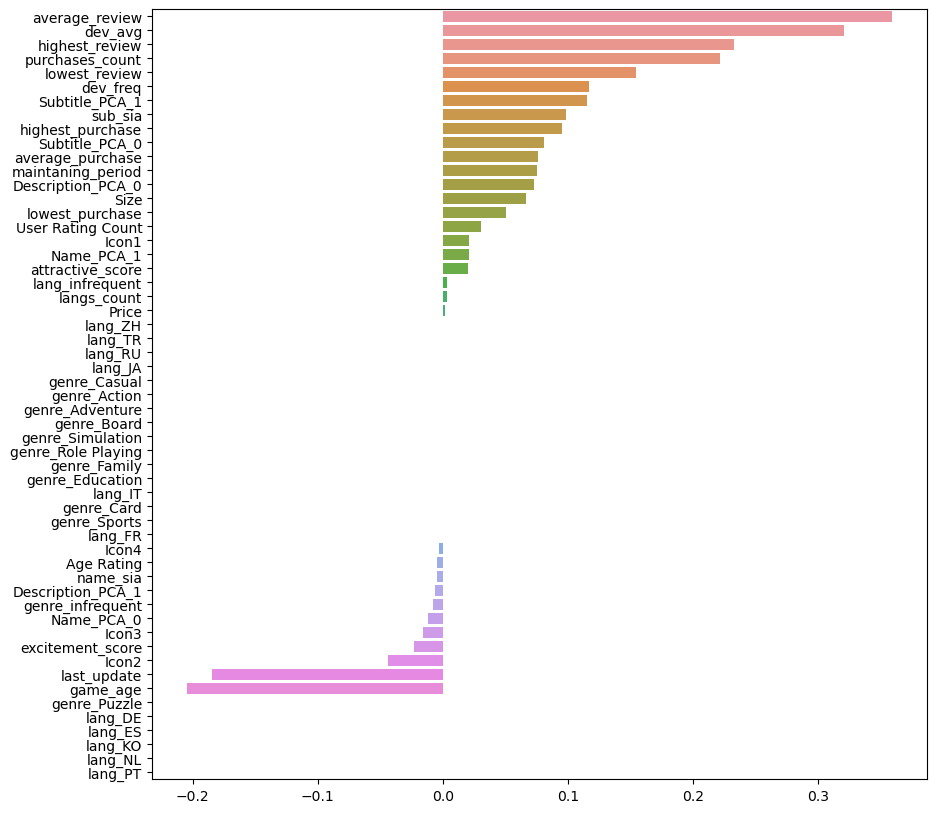

In [277]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corrwith(df_y)
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
# plt.show()

In [278]:
df.to_csv('df.csv', index=False)

In [279]:
selector = pickle.load(open('encoders/selector.pkl', 'rb'))
df = selector.transform(df)

## Models Evaluation

In [280]:
from sklearn.metrics import mean_squared_error, r2_score

In [281]:
### Linear Regression

lr_model = pickle.load(open('models/LR_model.pkl', 'rb'))
lr_pred = lr_model.predict(df)

# Calculate the MSE and coefficient of determination
lr_mse = mean_squared_error(df_y, lr_pred)
lr_r2 = r2_score(df_y, lr_pred)

# Print the results
print(f'Linear Regression MSE: {lr_mse}')
print(f'Linear Regression R2: {lr_r2}')

Linear Regression MSE: 0.34161154858666887
Linear Regression R2: 0.24321537092015855


In [282]:
### Lasso Regression

lasso_model = pickle.load(open('models/Lasso_model.pkl', 'rb'))
lasso_pred = lasso_model.predict(df)

# Calculate the MSE and coefficient of determination
lasso_mse = mean_squared_error(df_y, lasso_pred)
lasso_r2 = r2_score(df_y, lasso_pred)

# Print the results
print(f'Lasso Regression MSE: {lasso_mse}')
print(f'Lasso Regression R2: {lasso_r2}')

Lasso Regression MSE: 0.34195782198165264
Lasso Regression R2: 0.2424482587312785


In [283]:
### Ridge Regression

ridge_model = pickle.load(open('models/Ridge_model.pkl', 'rb'))
ridge_pred = ridge_model.predict(df)

# Calculate the MSE and coefficient of determination
ridge_mse = mean_squared_error(df_y, ridge_pred)
ridge_r2 = r2_score(df_y, ridge_pred)

# Print the results
print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Ridge Regression R2: {ridge_r2}')

Ridge Regression MSE: 0.34182229659921365
Ridge Regression R2: 0.24274849309602498


In [284]:
### ElasticNet Regression

en_model = pickle.load(open('models/ElasticNet_model.pkl', 'rb'))
en_pred = en_model.predict(df)

# Calculate the MSE and coefficient of determination
en_mse = mean_squared_error(df_y, en_pred)
en_r2 = r2_score(df_y, en_pred)
 
# Print the results
print(f'ElasticNet Regression MSE: {en_mse}')
print(f'ElasticNet Regression R2: {en_r2}')

ElasticNet Regression MSE: 0.3417893485243631
ElasticNet Regression R2: 0.2428214841781703


In [285]:
### Polynomial Regression

poly_model = pickle.load(open('models/Polynomial_model.pkl', 'rb'))
poly_features = pickle.load(open('encoders/poly.pkl', 'rb'))

poly_pred = poly_model.predict(poly_features.transform(df))

# Calculate the MSE and coefficient of determination
poly_mse = mean_squared_error(df_y, poly_pred)
poly_r2 = r2_score(df_y, poly_pred)

# Print the results
print(f'Polynomial Regression MSE: {poly_mse}')
print(f'Polynomial Regression R2: {poly_r2}')

Polynomial Regression MSE: 0.3307366411076467
Polynomial Regression R2: 0.2673069534701009


In [286]:
### Random Forest Regression

rfg_model = pickle.load(open('models/RandomForest_model.pkl', 'rb'))

rfg_pred = rfg_model.predict(df)

# Calculate the MSE and coefficient of determination
rfg_mse = mean_squared_error(df_y, rfg_pred)
rfg_r2 = r2_score(df_y, rfg_pred)

# Print the results
print(f'Random Forest Regression MSE: {rfg_mse}')
print(f'Random Forest Regression R2: {rfg_r2}')

Random Forest Regression MSE: 0.33777829008637944
Random Forest Regression R2: 0.25170732947457686


In [287]:
### XGBoost Regression

xgb_model = pickle.load(open('models/XGBoost_model.pkl', 'rb'))

xgb_pred = xgb_model.predict(df)

# Calculate the MSE and coefficient of determination
xgb_mse = mean_squared_error(df_y, xgb_pred)
xgb_r2 = r2_score(df_y, xgb_pred)

# Print the results
print(f'XGBoost Regression MSE: {xgb_mse}')
print(f'XGBoost Regression R2: {xgb_r2}')

XGBoost Regression MSE: 0.3283176071830674
XGBoost Regression R2: 0.27266592830253356


In [288]:
### Gradient Boosting Regression

gb_model = pickle.load(open('models/GradientBoosting_model.pkl', 'rb'))

gb_pred = gb_model.predict(df)

# Calculate the MSE and coefficient of determination
gb_mse = mean_squared_error(df_y, gb_pred)
gb_r2 = r2_score(df_y, gb_pred)

# Print the results
print(f'Gradient Boosting Regression MSE: {gb_mse}')
print(f'Gradient Boosting Regression R2: {gb_r2}')

Gradient Boosting Regression MSE: 0.3298932226231446
Gradient Boosting Regression R2: 0.26917540946227614


In [289]:
### CatBoost Regression

cb_model = pickle.load(open('models/CatBoost_model.pkl', 'rb'))

cb_pred = cb_model.predict(df)

# Calculate the MSE and coefficient of determination
cb_mse = mean_squared_error(df_y, cb_pred)
cb_r2 = r2_score(df_y, cb_pred)

# Print the results
print(f'CatBoost Regression MSE: {cb_mse}')
print(f'CatBoost Regression R2: {cb_r2}')

CatBoost Regression MSE: 0.32043882044205274
CatBoost Regression R2: 0.29012009437527453


In [290]:
# AdaBoost Regression

ada_model = pickle.load(open('models/AdaBoost_model.pkl', 'rb'))

ada_pred = ada_model.predict(df)

# Calculate the MSE and coefficient of determination
ada_mse = mean_squared_error(df_y, ada_pred)
ada_r2 = r2_score(df_y, ada_pred)

# Print the results
print(f'AdaBoost Regression MSE: {ada_mse}')
print(f'AdaBoost Regression R2: {ada_r2}')


AdaBoost Regression MSE: 0.35554490630450863
AdaBoost Regression R2: 0.21234829105720454
